In [ ]:
!pip install --upgrade timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 897.2 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [ ]:
pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 kB 865.6 kB/s eta 0:00:00
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.15
    Uninstalling fastai-2.7.15:
      Successfully uninstalled fastai-2.7.15


In [ ]:
import os
import timm
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as album
from albumentations.pytorch import ToTensorV2
from torch.utils.data import random_split
#완전히 fastai 체계에서 돌리기
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.callback.all import *
from torch.optim import lr_scheduler
from fastai.callback.wandb import *
from types import SimpleNamespace  # Import SimpleNamespace
from sklearn.metrics import f1_score
import wandb

In [5]:
wandb.require("core")
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#모델 고르시오
timm.list_models('efficient-b0',pretrained=True)
#모델 고르시오
timm.list_models('resnet50',pretrained=True)

['resnet50.a1_in1k',
 'resnet50.a1h_in1k',
 'resnet50.a2_in1k',
 'resnet50.a3_in1k',
 'resnet50.am_in1k',
 'resnet50.b1k_in1k',
 'resnet50.b2k_in1k',
 'resnet50.bt_in1k',
 'resnet50.c1_in1k',
 'resnet50.c2_in1k',
 'resnet50.d_in1k',
 'resnet50.fb_ssl_yfcc100m_ft_in1k',
 'resnet50.fb_swsl_ig1b_ft_in1k',
 'resnet50.gluon_in1k',
 'resnet50.ra_in1k',
 'resnet50.ram_in1k',
 'resnet50.tv2_in1k',
 'resnet50.tv_in1k']

In [ ]:
# Define your project and group name
PROJECT_NAME = "k-fold-cross-validation-pytorch"
GROUP_NAME = "experiment-" + wandb.util.generate_id()
JOB_TYPE = 'train'

# 경로 및 기본설정
base_path = 'data/'
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_classes= 17

# training config
config = SimpleNamespace(
    batch_size=16,
    img_size=448,
    seed=42,
    pretrained=True,
    model_name='efficientnet-b0', # 'resnet50' 'efficientnet-b0', ...,
    epochs=100,
    learning_rate=1e-3,
    num_workers=0,
    focal_gamma = 2,
    smoothing = 0.1,
    focal_alpha = [1.0]*num_classes, #alpha = [1.0] * num_classes  # 모든 클래스에 대해 동일한 가중치 #alpha = [0.5, 1.0, 0.8, ...]  # 또는 클래스별로 다른 가중치 설정 클래스 수에 맞게 설정
    mixup_alpha=1.0,
    cutmix_alpha=1.0,
    mixup_prob=0.3,
    cutmix_prob=0.3,
    loss = 'smoothfocal',
    num_classes = 17
    )
device

'cpu'

### LOSS 함수 참조
if config.loss == 'ce':
    loss_func = CELoss(num_classes=config.num_classes)

elif config.loss == 'focal':
    loss_func = FocalLoss(num_classes=config.num_classes, alpha=config.focal_alpha, gamma=config.focal_gamma)

elif config.loss == 'smoothce':
    loss_func = SmoothCELoss(num_classes=config.num_classes, smoothing=config.smoothing)

elif config.loss == 'smoothfocal':
    loss_func = SmoothFocalLoss(num_classes=config.num_classes, alpha=config.focal_alpha, gamma=config.focal_gamma, smoothing=config.smoothing)
    
else:
    raise ValueError(f"Unsupported loss function: {config.loss}")

데이터셋

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, int(target)  # 타겟을 정수로 반환

def get_transform(img_size, mean, std):
    return album.Compose([
        album.LongestMaxSize(max_size=img_size),
        album.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=(0,0,0)),
        album.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ])

def create_data_set(base_path, img_size= 448, mean = (0.485, 0.456, 0.406), std= (0.229, 0.224, 0.225)):
    # 경로 설정
    train_csv = os.path.join(base_path, "augmented_train/augmented_train.csv")
    train_dir = os.path.join(base_path, "augmented_train")
    test_csv = os.path.join(base_path, "sample_submission.csv")
    test_dir = os.path.join(base_path, "test")

    # Dataset 정의
    trn_dataset = ImageDataset(
        train_csv,
        train_dir,
        transform=get_transform(img_size, mean, std)
    )
    tst_dataset = ImageDataset(
        test_csv,
        test_dir,
        transform=get_transform(img_size, mean, std)
    )

    print(f"Training dataset size: {len(trn_dataset)}")
    print(f"Test dataset size: {len(tst_dataset)}")
    return trn_dataset, tst_dataset

손실함수

In [ ]:
class SmoothFocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=None, gamma=2, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma
        self.smoothing = smoothing

        if alpha is None:
            self.alpha = torch.ones(num_classes)
        else:
            self.alpha = torch.tensor(alpha)

        self.alpha = self.alpha / self.alpha.sum()

    def forward(self, inputs, targets):
        inputs = inputs.float()

        # 타겟이 클래스 인덱스인 경우 원-핫 인코딩으로 변환
        if targets.dim() == 1:
            targets = F.one_hot(targets, num_classes=self.num_classes).float()

        # 라벨 스무딩 적용
        targets_smooth = (1 - self.smoothing) * targets + self.smoothing / self.num_classes

        log_probs = F.log_softmax(inputs, dim=1)
        loss = -targets_smooth * log_probs

        pt = torch.exp(-loss)
        focal_loss = (1 - pt)**self.gamma * loss

        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
            focal_loss = alpha.unsqueeze(0) * focal_loss

        return focal_loss.sum(dim=1).mean()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=None, gamma=2):
        super().__init__()
        self.num_classes = num_classes
        self.gamma = gamma

        if alpha is None:
            self.alpha = torch.ones(num_classes)
        else:
            self.alpha = torch.tensor(alpha)

        self.alpha = self.alpha / self.alpha.sum()

    def __call__(self, inputs, targets):
        inputs = inputs.float()

        # 타겟이 클래스 인덱스인 경우 원-핫 인코딩으로 변환
        if targets.dim() == 1:
            targets = F.one_hot(targets, num_classes=self.num_classes).float()

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss

        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
            focal_loss = alpha.unsqueeze(0) * focal_loss

        return focal_loss.mean()

In [ ]:
class CELoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def __call__(self, inputs, targets):
        inputs = inputs.float()

        # 타겟이 클래스 인덱스인 경우 원-핫 인코딩으로 변환
        if targets.dim() == 1:
            targets = F.one_hot(targets, num_classes=self.num_classes).float()

        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        return ce_loss.mean()

In [ ]:
class SmoothCELoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing

    def __call__(self, inputs, targets):
        inputs = inputs.float()

        # 타겟이 클래스 인덱스인 경우 원-핫 인코딩으로 변환
        if targets.dim() == 1:
            targets = F.one_hot(targets, num_classes=self.num_classes).float()

        # 라벨 스무딩 적용
        targets_smooth = (1 - self.smoothing) * targets + self.smoothing / self.num_classes

        log_probs = F.log_softmax(inputs, dim=1)
        loss = -targets_smooth * log_probs

        return loss.sum(dim=1).mean()

메트릭

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=False):
    "Compute accuracy by selecting the label with the highest probability"
    if sigmoid:
        inp = inp.sigmoid()
    else:
        inp = F.softmax(inp, dim=1)

    pred = inp.argmax(dim=1)
    return (pred == targ).float().mean()

def f1_score_func(preds, targets, average='macro'):
    preds = preds.argmax(dim=1).cpu().numpy()
    targets = targets.cpu().numpy()
    return f1_score(targets, preds, average=average)

In [ ]:
f1_macro = partial(f1_score_func, average='macro')
f1_weighted = partial(f1_score_func, average='weighted')

스케줄러

In [ ]:
class BaseSchedCB(Callback):
    def __init__(self, sched):
        super().__init__()
        self.sched = sched
        self.schedo = None

    def before_fit(self):
        self.schedo = self.sched(self.learn.opt)

    def _step(self):
        if self.training and self.schedo is not None:
            self.schedo.step()

class BatchSchedCB(BaseSchedCB):
    def after_batch(self):
        self._step()

mixup/cutmix

In [ ]:
class MixupCutmixCallback(Callback):
    def __init__(self, mixup_alpha=1.0, cutmix_alpha=1.0, mixup_prob=0.5, cutmix_prob=0.5):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.mixup_prob = mixup_prob
        self.cutmix_prob = cutmix_prob

    def before_batch(self):
        if not self.training: return

        r = np.random.rand()
        if r < self.mixup_prob:
            self.mixup()
        elif r < self.mixup_prob + self.cutmix_prob:
            self.cutmix()
        # 아무것도 적용되지 않는 경우: r >= self.mixup_prob + self.cutmix_prob

    def mixup(self):
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        rand_index = torch.randperm(self.yb[0].size(0)).to(self.xb[0].device)

        mixed_x = lam * self.xb[0] + (1 - lam) * self.xb[0][rand_index]

        targets = self.yb[0]
        if targets.dim() == 1:
            targets = F.one_hot(targets, num_classes=17).float()

        mixed_y = lam * targets + (1 - lam) * targets[rand_index]

        self.learn.xb = (mixed_x,)
        self.learn.yb = (mixed_y,)

    def cutmix(self):
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        rand_index = torch.randperm(self.yb[0].size(0)).to(self.xb[0].device)

        bbx1, bby1, bbx2, bby2 = self.rand_bbox(self.xb[0].size(), lam)
        self.xb[0][:, :, bbx1:bbx2, bby1:bby2] = self.xb[0][rand_index, :, bbx1:bbx2, bby1:bby2]

        targets = self.yb[0]
        if targets.dim() == 1:
            targets = F.one_hot(targets, num_classes=17).float()

        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (self.xb[0].size()[-1] * self.xb[0].size()[-2]))
        mixed_y = lam * targets + (1 - lam) * targets[rand_index]

        self.learn.xb = (self.xb[0],)
        self.learn.yb = (mixed_y,)

    def rand_bbox(self, size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

스케줄러- 아직 미구현

In [ ]:
class BaseSchedCB(Callback): # basic nuts and bolts
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

class BatchSchedCB(BaseSchedCB): # use this class if you want your scheduler to update the learning rate every batch
    def after_batch(self, learn): self._step(learn)

In [ ]:
tmax = config.epochs * len(dls.train) # total batches = epochs * batches per epoch
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)
batch_sched_cb = BatchSchedCB(sched)

NameError: name 'dls' is not defined

실행함수- 데이터셋

In [ ]:
trn_dataset, tst_dataset = create_data_set(base_path, config.img_size)
train_size = int(0.9 * len(trn_dataset))
val_size = len(trn_dataset) - train_size
train_ds, val_ds = random_split(trn_dataset, [train_size, val_size])
# DataLoader 정의
trn_loader_split = DataLoader(
    train_ds,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
    drop_last=False
)
val_loader_split = DataLoader(
    val_ds,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)
dls = DataLoaders(trn_loader_split, val_loader_split,  device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'data/augmented_train/augmented_train.csv'

손실함수 결정

In [ ]:
if config.loss == 'ce':
    loss_func = CELoss(num_classes=config.num_classes)
elif config.loss == 'focal':
    loss_func = FocalLoss(num_classes=config.num_classes, alpha=config.focal_alpha, gamma=config.focal_gamma)
elif config.loss == 'smoothce':
    loss_func = SmoothCELoss(num_classes=config.num_classes, smoothing=config.smoothing)
elif config.loss == 'smoothfocal':
    loss_func = SmoothFocalLoss(num_classes=config.num_classes, alpha=config.focal_alpha, gamma=config.focal_gamma, smoothing=config.smoothing)
else:
    raise ValueError(f"Unsupported loss function: {config.loss}")

#cbs = [MixedPrecision(), WandbCallback(log_preds=False), SaveModelCallback(every_epoch=True), MixupCutmixCallback(mixup_alpha=1.0, mixup_prob=0.3, cutmix_alpha= 1.0, cutmix_prob= 0.3), BatchSchedCB(sched)]

In [ ]:
def train(config):
    "Train the model using the supplied config"
    #dls = DataLoaders(trn_loader_split, val_loader_split)
    with wandb.init(project=PROJECT_NAME, group=GROUP_NAME, job_type=JOB_TYPE, config=config):
        #콜백 설정, wandb, saving, cutmix/mixup, precision등
        cbs = [MixedPrecision(), WandbCallback(log_preds=False), SaveModelCallback(every_epoch=True), MixupCutmixCallback(mixup_alpha=config.mixup_alpha, cutmix_alpha=config.cutmix_alpha, mixup_prob=config.mixup_prob, cutmix_prob=config.cutmix_prob), BatchSchedCB(sched)]
        #러너 설정
        learn = vision_learner(dls, config.model_name, metrics = [accuracy_multi,partial(f1_score_func, average='macro'), partial(f1_score_func, average='weighted')],
                       cbs=cbs, pretrained=config.pretrained, opt_func=Adam, loss_func=loss_func, n_out=num_classes, normalize=False)
        learn.callbacks.append(sched)
        learn.fine_tune(config.epochs, config.learning_rate)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


SuggestedLRs(valley=0.0063095735386013985)

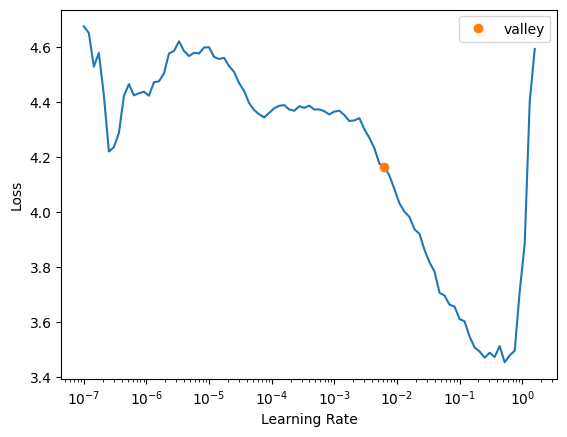

In [ ]:
learn = vision_learner(dls, config.model_name, metrics = [accuracy_multi,partial(f1_macro, average='macro'), partial(f1_weighted, average='weighted')], pretrained=config.pretrained, opt_func=ranger, loss_func=loss_func, n_out=num_classes, normalize=False)
learn.lr_find()

In [ ]:
with wandb.init(project=PROJECT_NAME, group=GROUP_NAME, job_type=JOB_TYPE, config=config):
    cbs = [MixedPrecision(), WandbCallback(log_preds=False), SaveModelCallback(every_epoch=True), MixupCutmixCallback(mixup_alpha=1.0, mixup_prob=0.3, cutmix_alpha= 1.0, cutmix_prob= 0.3)]
    learn = vision_learner(dls, config.model_name, metrics = [accuracy_multi,f1_macro, f1_weighted],
                    cbs=cbs, pretrained=config.pretrained, opt_func=ranger, lr = 0.00631, loss_func=loss_func, n_out=num_classes, normalize=False)
    # GROUP_NAME을 사용하여 모델 파일 이름 생성
    model_filename = f'{GROUP_NAME}_model.pkl'

    # 초기 모델 저장 (피클 형식)
    learn.save(f'{model_filename}')

    # 코사인 어닐링 스케줄러를 사용한 학습
    learn.fit_flat_cos(config.epochs, config.learning_rate)

    # 학습 후 최종 모델 저장 (피클 형식)
    learn.save(f'{GROUP_NAME}_final_model.pkl')

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Could not gather input dimensions


epoch,train_loss,valid_loss,accuracy_multi,f1_score_func,f1_score_func,time


체크 포인트 불러와서 추론하기

In [ ]:
#체크 포인트
with wandb.init(project=PROJECT_NAME, group=GROUP_NAME, job_type=JOB_TYPE, config=config):
    cbs = [MixedPrecision(), WandbCallback(log_preds=False), SaveModelCallback(every_epoch=True), MixupCutmixCallback(mixup_alpha=1.0, mixup_prob=0.3, cutmix_alpha= 1.0, cutmix_prob= 0.3)]
    learn2 = vision_learner(dls, config.model_name, metrics = [accuracy_multi,f1_macro, f1_weighted],
                    cbs=cbs, pretrained=config.pretrained, opt_func=ranger, lr = 0.00631, loss_func=loss_func, n_out=num_classes, normalize=False)
    learn2.load('model_5')

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnetv2_rw_t.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnetv2_rw_t.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
c:\Users\hhh\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [ ]:
# WandbCallback 제거
learn2.remove_cb(WandbCallback)
# 이제 validate를 실행할 수 있습니다
valid_metrics = learn2.validate()

In [ ]:
valid_metrics

(#4) [40.97358322143555,0.2440764307975769,0.15115867212314132,0.18561098773837637]

결과 도식화

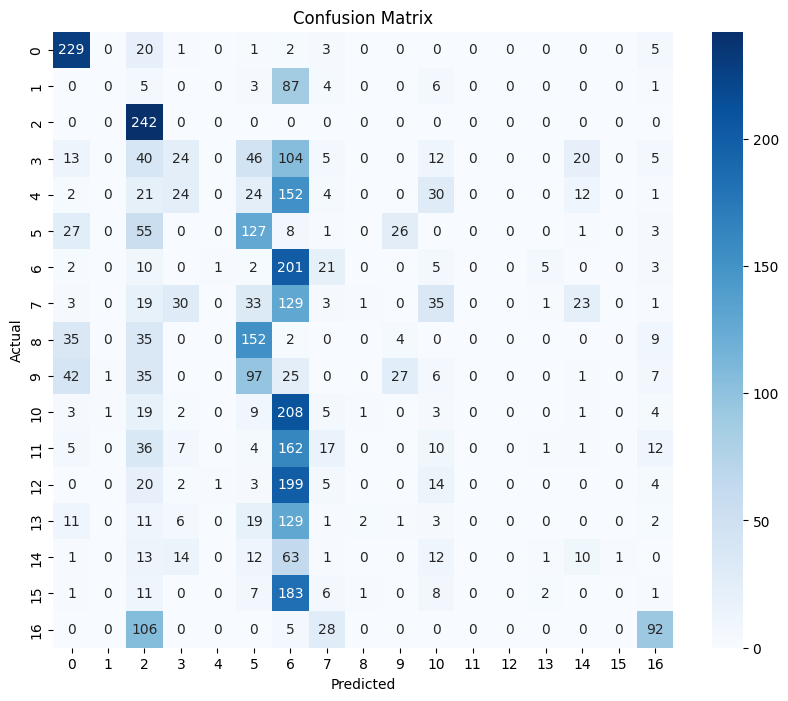

In [ ]:
from fastai.vision.all import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 검증 데이터에 대한 예측 수행
preds, targets = learn2.get_preds(dl=learn2.dls.valid)
pred_class = preds.argmax(dim=1)

# 혼동 행렬 계산
cm = confusion_matrix(targets, pred_class)
class_names = [str(i) for i in range(cm.shape[0])]

# 혼동 행렬 시각화
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


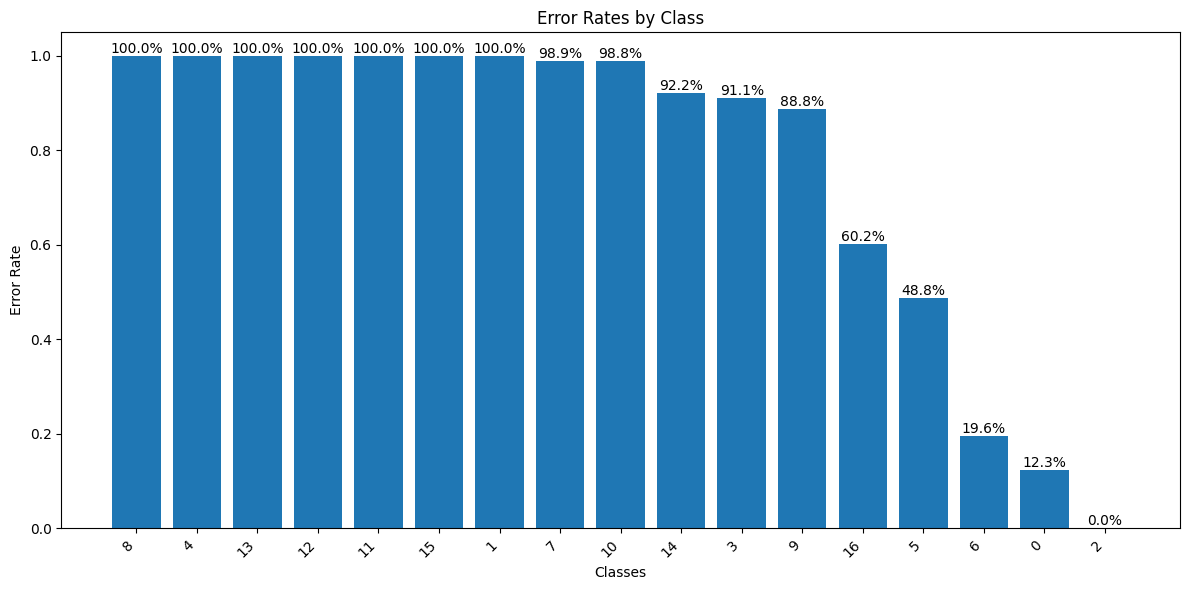


Classes sorted by error rate (highest to lowest):
Class 8: Error rate = 100.0%
Class 4: Error rate = 100.0%
Class 13: Error rate = 100.0%
Class 12: Error rate = 100.0%
Class 11: Error rate = 100.0%
Class 15: Error rate = 100.0%
Class 1: Error rate = 100.0%
Class 7: Error rate = 98.9%
Class 10: Error rate = 98.8%
Class 14: Error rate = 92.2%
Class 3: Error rate = 91.1%
Class 9: Error rate = 88.8%
Class 16: Error rate = 60.2%
Class 5: Error rate = 48.8%
Class 6: Error rate = 19.6%
Class 0: Error rate = 12.3%
Class 2: Error rate = 0.0%


In [ ]:
# 각 클래스별 오류율 계산
error_rates = (cm.sum(axis=1) - cm.diagonal()) / cm.sum(axis=1)
# 오류율이 높은 순서대로 정렬
sorted_indices = np.argsort(error_rates)[::-1]
sorted_class_names = [class_names[i] for i in sorted_indices]
sorted_error_rates = error_rates[sorted_indices]

# 막대 차트 생성
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_class_names)), sorted_error_rates, align='center')
plt.xlabel('Classes')
plt.ylabel('Error Rate')
plt.title('Error Rates by Class')
plt.xticks(range(len(sorted_class_names)), sorted_class_names, rotation=45, ha='right')

# 각 막대 위에 오류율 표시 (소수점 첫째자리까지)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{sorted_error_rates[i]:.1%}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 오류율 출력 (텍스트로)
print("\nClasses sorted by error rate (highest to lowest):")
for name, rate in zip(sorted_class_names, sorted_error_rates):
    print(f"Class {name}: Error rate = {rate:.1%}")

In [ ]:
# 테스트 세트에 대한 예측
test_preds, _ = learn2.get_preds(dl=tst_loader)

# 예측 결과를 numpy 배열로 변환
test_preds_np = test_preds.numpy()

# 클래스 레이블 예측 (다중 분류의 경우)
predicted_classes = np.argmax(test_preds_np, axis=1)

In [ ]:
len(predicted_classes), len(tst_dataset)

(3140, 3140)

GPU 관리

 nvidia-smi

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import torch

def print_gpu_memory():
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

print_gpu_memory()

Allocated: 27.51 GB
Cached: 27.72 GB


실험

In [ ]:
def print_data_info(dls):
    for name, dl in [("train", dls.train), ("valid", dls.valid)]:
        batch = next(iter(dl))
        x, y = batch
        print(f"{name} data:")
        print(f"  Input shape: {x.shape}")
        print(f"  Target shape: {y.shape}")
        print(f"  Target unique values: {y.unique()}")

print_data_info(dls)

train data:
  Input shape: torch.Size([16, 3, 224, 224])
  Target shape: torch.Size([16])
  Target unique values: tensor([ 3,  4,  6,  7,  8,  9, 11, 13, 14, 15])
valid data:
  Input shape: torch.Size([16, 3, 224, 224])
  Target shape: torch.Size([16])
  Target unique values: tensor([ 0,  4,  5,  6,  7,  8,  9, 10, 12, 13, 15])


In [ ]:
def print_model_output(learn):
    x, _ = next(iter(learn.dls.train))
    with torch.no_grad():
        output = learn.model(x.to(device))
    print(f"Model output shape: {output.shape}")
    print(f"Model output sample: {output[0]}")

print_model_output(learn)

Model output shape: torch.Size([16, 17])
Model output sample: tensor([-0.3076,  0.6699, -2.0020, -0.3252, -3.4238, -1.0713, -0.6006,  1.6484,
         1.5371, -0.2178, -2.1484,  0.6475,  0.7212, -0.4165, -0.1462,  0.4041,
         1.2256], device='cuda:0', dtype=torch.float16)
